In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, RBF, ConstantKernel as C, WhiteKernel

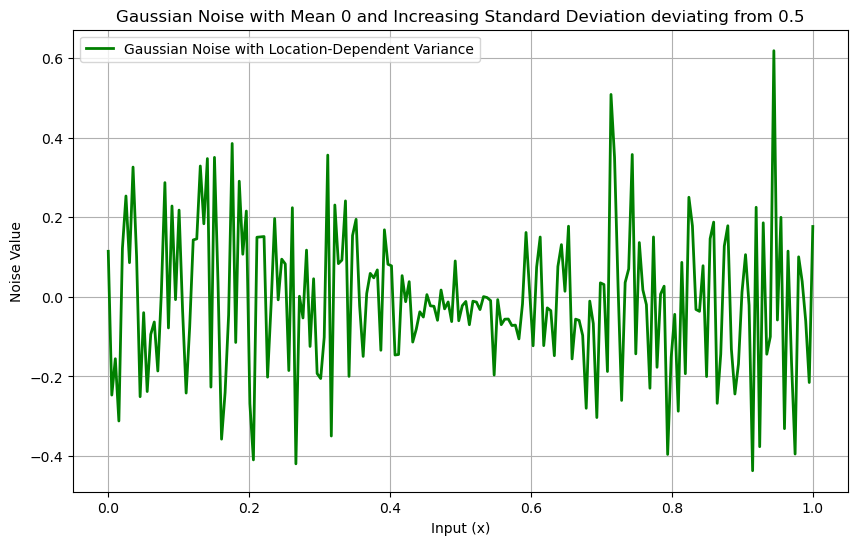

In [95]:
#### IMPORTANT: Set seed!

SEED = 12345

# Define a Gaussian noise function with location-dependent variance
def gaussian_noise(x, max_noise_level=0.2):
    """
    Creates a Gaussian noise with mean 0 and standard deviation that increases with x.
    Larger x results in higher noise variance.
    
    Parameters:
    - x: Input values for which to generate noise.
    - scale_factor: Controls how quickly the noise increases as x increases.
    - max_noise_level: The maximum possible noise amplitude.
    
    Returns:
    - Noise values at each input x.
    """

    # Define the function with plateaus and a dip in the middle
    def plateau_with_dip(x):
        plateau_height = 1.0  # Height of the plateau on both sides
        dip_center = 0.5      # Center of the dip
        dip_width = 0.1       # Width of the dip (controls sharpness of the dip)
        dip_depth = 0.8       # Depth of the dip
        
        # Plateau value minus a Gaussian-shaped dip
        return plateau_height - dip_depth * np.exp(-((x - dip_center) ** 2) / (2 * dip_width ** 2))
    
    scale_factor = plateau_with_dip(x)
    # Standard deviation that increases with x, scaled by a factor
    std_dev = scale_factor * max_noise_level
    
    # Clip the standard deviation so it doesn't get too large
    std_dev = np.minimum(std_dev, max_noise_level)
    
    # Generate Gaussian noise with mean 0 and increasing standard deviation
    noise = np.random.normal(loc=0, scale=std_dev)
    
    return noise

# Define the input range
X_plot = np.linspace(0, 1, 200)

# Generate noise values
noise_values = np.array([gaussian_noise(x) for x in X_plot])

# Plot the noise function
plt.figure(figsize=(10, 6))
plt.plot(X_plot, noise_values, color="green", lw=2, label="Gaussian Noise with Location-Dependent Variance")
plt.xlabel("Input (x)")
plt.ylabel("Noise Value")
plt.title("Gaussian Noise with Mean 0 and Increasing Standard Deviation deviating from 0.5")
plt.legend()
plt.grid(True)
plt.show()


In [102]:
# Define a realistic yield function with multiple optima
def true_function(x):
    # Two Gaussian peaks at x = 0.3 and x = 0.8
    peak1 = 1 * np.exp(-((x - 0.4) ** 2) / 0.05)
    peak2 = 0.8 * np.exp(-((x - 0.8) ** 2) / 0.02)
    return peak1 + peak2

# Generate training data with heteroscedastic noise, only within [0, 1] range
np.random.seed(SEED)
X_train = np.random.rand(20, 1) + 0.2
y_train = true_function(X_train).ravel() + gaussian_noise(X_train).ravel()

# Define test points for predictions, extending beyond the training range
X_test = np.linspace(0, 1.5, 200).reshape(-1, 1)
y_true = true_function(X_test).ravel()


In [158]:
# Define kernels
# Define different kernel configurations
kernels = {
    'RBF': C(1.0, (1e-1, 1e1)) * RBF(length_scale=0.001, length_scale_bounds=(1e-2, 5)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1)),
    'Matern_3/2': C(1.0, (1e-2, 1e2)) * Matern(length_scale=0.001, length_scale_bounds=(1e-2, 5), nu=1.5) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1)),
    'Matern_1/2': C(1.0, (1e-2, 1e2)) * Matern(length_scale=0.001, length_scale_bounds=(1e-2, 5), nu=0.5) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5, 1e1))
}

# Define different prior means
prior_means = {
    'Constant_0': lambda x: np.zeros(x.shape[0]),  # Constant prior (0)
    'Constant_1': lambda x: np.ones(x.shape[0]),  # Constant prior (0)
    'Linear': lambda x: 0.5 * x  # Linear prior assumption
}


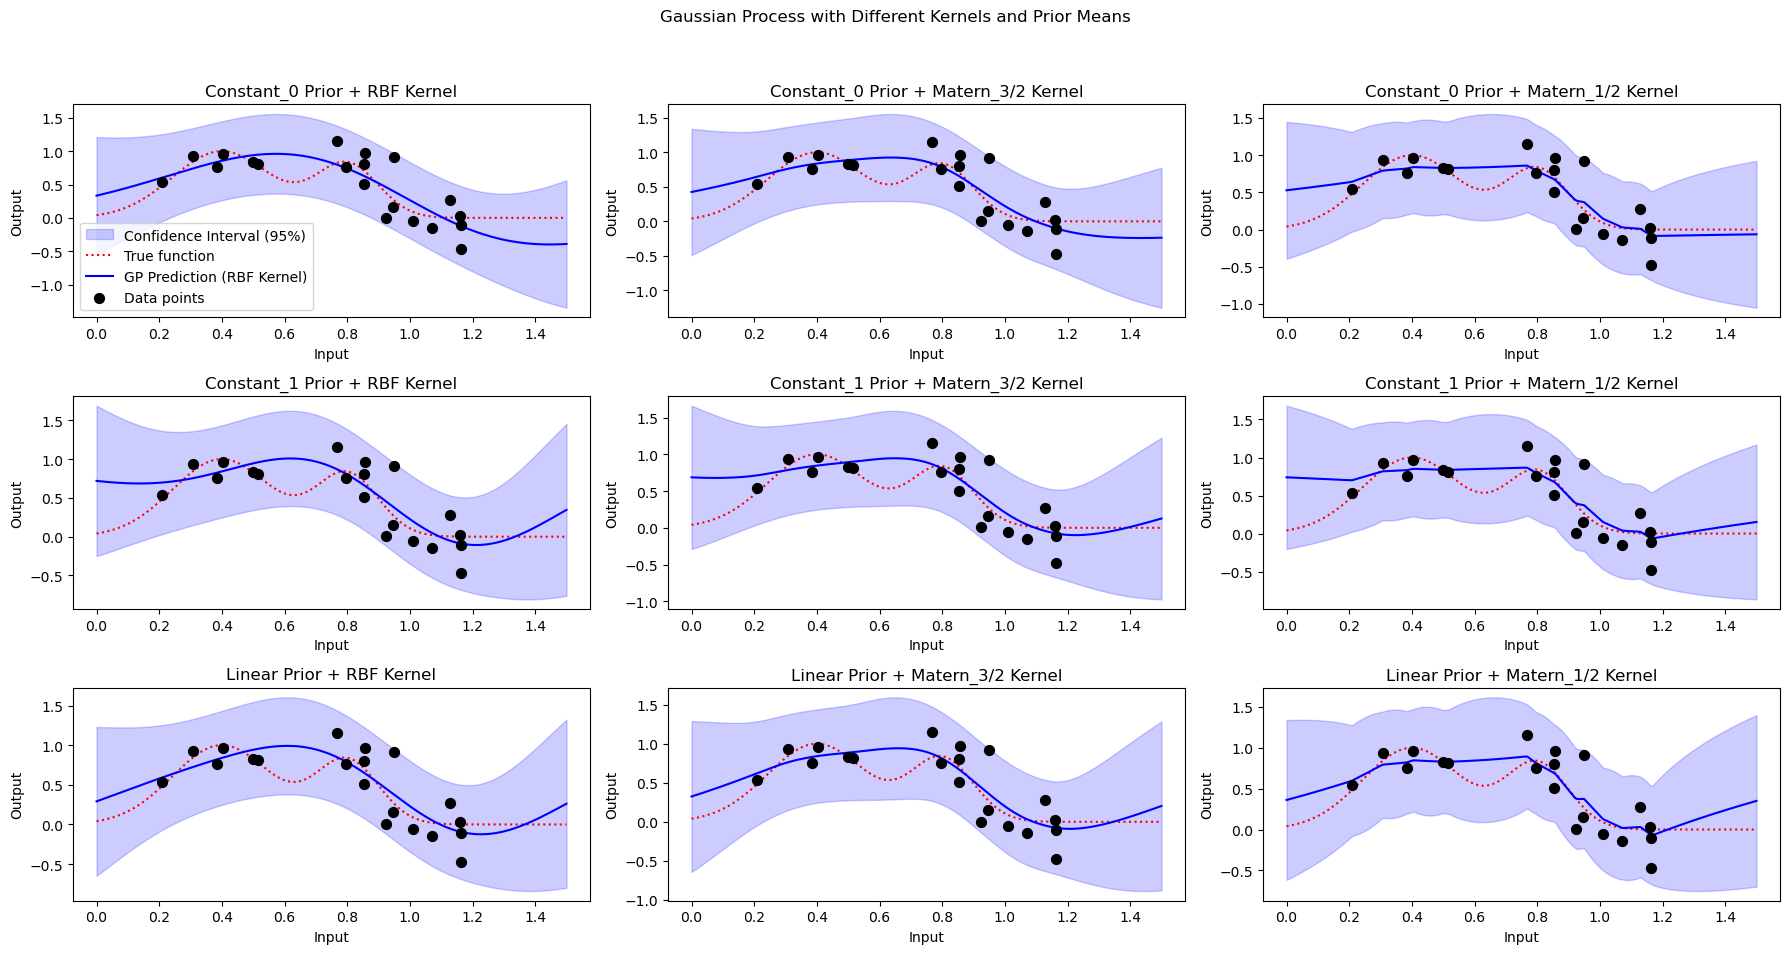

In [159]:
# Set up plot grid
fig, axs = plt.subplots(len(prior_means), len(kernels), figsize=(18, 10))
fig.suptitle('Gaussian Process with Different Kernels and Prior Means')

# Run GP with each combination of kernel and prior mean
for i, (prior_name, prior_mean) in enumerate(prior_means.items()):
    for j, (kernel_name, kernel) in enumerate(kernels.items()):
        
        # Create and fit the GP model
        gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0, n_restarts_optimizer=10, normalize_y=False)
        
        # Fit the model using the modified target values according to the prior mean
        y_adjusted_train = y_train - prior_mean(X_train).ravel()
        gp.fit(X_train, y_adjusted_train)
        
        # Make predictions and add the prior mean back to the predictions
        y_pred, sigma = gp.predict(X_test, return_std=True)
        y_pred += prior_mean(X_test).ravel()
        
        # Plot the results for the current model
        ax = axs[i, j]
        ax.fill_between(X_test.ravel(), y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, alpha=0.2, color='blue', label="Confidence Interval (95%)")
        ax.plot(X_test, y_true, 'r:', label="True function")
        ax.plot(X_test, y_pred, 'b-', label=f"GP Prediction ({kernel_name} Kernel)")
        ax.scatter(X_train, y_train, c='black', s=50, zorder=10, edgecolors=(0, 0, 0), label="Data points")
        ax.set_title(f"{prior_name} Prior + {kernel_name} Kernel")
        ax.set_xlabel("Input")
        ax.set_ylabel("Output")
        if i == 0 and j == 0:
            ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()